# Import libraries

In [1]:
import os
import sys
import visualkeras
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from PIL import Image

from tensorflow.keras import models
from tensorflow.keras import utils
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.models import Sequential, save_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Input, Convolution2D, MaxPooling2D, ZeroPadding2D, Layer, InputSpec
from tensorflow.keras.preprocessing.image import DirectoryIterator,ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, VGG16, ResNet152


from sklearn.metrics import confusion_matrix

## Helper methods

In [2]:
base_path = './data/'
train_path = './data/train/'
test_path = './data/test/'
#validation_path = './images/validation/'

In [3]:
def get_misclassifications(model):
    preds = model.predict(validation_gen)
    y_preds = [np.argmax(probas) for probas in preds]
    y_test = validation_gen.classes
    
    df = pd.DataFrame([y_test,y_preds,validation_gen.filenames]).T
    df.rename(columns={ 0:'true_class',
                        1:'predicted_class',
                        2:'filename'
                      }, inplace=True)
    return df.loc[df['true_class'] != df['predicted_class'],:]

In [4]:
def plot_acc_loss(history):
    
    ''' Function to plot loss and accuracy for both train and validation sets, over number of epochs'''
    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    epoch_labels = history.epoch
    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Categorical Crossentropy')
    axes[0].legend(fontsize=10);
    
    # Generate line plot of training, testing loss over epochs.
    axes[1].plot(train_acc, label='Training Accuracy', color='green')
    axes[1].plot(test_acc, label='Test Accuracy', color='red')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Categorical Crossentropy')
    axes[1].legend(fontsize=10);

In [5]:
def plot_heatmap(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    
    ''' Function to plot confusion matrix against classes'''
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    


## Train, Test, Split

The ImageDataGenerator is very useful for splitting between train and validation data for fitting later. Additionally, it allows real-time augmentation of data during the fitting phase.

I have specified a 75:25 split of training vs validation data here, with a few hyperparameters for data augmentation:
- Adjustable range of brightness
- Rotation to the left and right of 30 degrees
- Shearing of images by factor of 0.2
- Shifting of channel values
- Image shearing
- Image zooming

Here, I've also initialise `batch_size` and `steps_per_epoch` based on the sample, and batch size, the latter which can be adjusted based on the amount of data.

In [6]:
batch_size = 128
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.25,
                                   brightness_range=[0.4,1.5],
                                   rotation_range=30,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   fill_mode='nearest',
                                   channel_shift_range=10
                                  )

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(48,48),
    seed=42,
    subset='training',
    color_mode='rgb',
    batch_size=batch_size,
    #save_to_dir='./results/'
)

validation_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(48,48),
    seed=42,
    subset='validation',
    color_mode='rgb'
)

sample_size = train_gen.classes.shape[0]

Found 23960 images belonging to 8 classes.
Found 7982 images belonging to 8 classes.


In [7]:
steps_per_epoch = np.ceil(sample_size/batch_size)

## Initialise EarlyStopping, Checkpoints and Reduction of learning rates for modelling

This function will create `EarlyStopping`, `Checkpoints`, and `ReduceLRonPlateau` as callbacks for each of the models I will run below. As I'm focused more on accuracy, the monitoring is set to `val_accuracy` to use the best validation accuracy as a benchmark.

The checkpoint saves each model whenever it performs better than the last best validation accuracy. This allows the model to preserve the best point of the model during fitting. It also helps to create the model at it's best point so I don't forget to save the model after completion of fitting.

Reduction of Learning rate on plateauing reduces the learning rate when there are no improvements for a set number of epochs (set as `patience = 3`).

In [24]:
def callbacks(filename):
    early = EarlyStopping(monitor='val_accuracy', 
                          patience=7,
                          verbose=1,
                          restore_best_weights=True,
                          mode='auto'
                         )
    checkpoint = ModelCheckpoint(f'./models/{filename}.h5',
                                monitor='val_accuracy',
                                mode='auto',
                                save_best_only=True,
                                verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                  mode='auto',
                                  factor=0.2,
                                  patience=3,
                                  verbose=1,
                                  min_delta=0.0001)
    return early, checkpoint, reduce_lr

In [25]:
class_size = len(train_gen.class_indices)
class_names = validation_gen.class_indices.keys()
class_vals = validation_gen.class_indices.values()

# Models

I define a list of custom models in functional form so they can be adjusted easily. As the model is compiled at the end, this allows the model to be used directly after calling the functions.

Additionally, should there be a need to extend or add additional layers to these models, I can also just add it in code separately. However, they need to be re-compiled again.

Under this section, I used a custom model, and also adapted some models from the Visual Geometry Group (VGG), such as the VGG16, Resnet50 and Resnet152. I will explore transfer learning in the adapted models. 

For this classification task, I require an output of 8 classes. Pre-trained models have different output classes by default in their architecture. By default, VGG16 outputs 1000 classes, based on the Imagenet Large Scale Visual Recognition Challenge in 2014 (ILSVRC2014). To adapt the pre-trained models to our classification task, I will remove the last layer and connect our connected Dense and output layers.


## Custom Model

The custom model is a basic model comprising of 4 convolutional layers, before flattening and adding 4 additional fully connected layers. Each layer has a dropout function to reduce overfitting and to average the model over time. This results in 1,743,560 trainable parameters.

In [9]:
def custom_model(num_classes):
    model = Sequential()
    
    # 1st Convolution Layer
    model.add(Conv2D(64,(3,3), input_shape=(48, 48,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(128,kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    # 3rd Convolution layer
    model.add(Conv2D(256,kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Convolution layer
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Fully connected layer 2nd layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Fully connected layer 3rd layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Fully connected layer 4th layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    return model

## VGG16

The VGG16 model is one of the most popular pre-trained models for image classification purposes. The model consists of 5 convolutional layers, then 3 fully connected layers, followed by 1 output layer. As mentioned earlier, I remove the last layer and connect our connected layers with the output layer conforming to our number of classifications.

VGG16 results in 14,946,248 trainable parameters.

In [10]:
def vgg16_model(num_classes):
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
    add_model = Flatten()(vgg_model.layers[-1].output)
    add_model = Dense(256, activation='relu')(add_model)
    add_model = Dense(256, activation='relu')(add_model)
    add_model = BatchNormalization()(add_model)
    add_model = Dropout(0.4)(add_model)
    add_model = Dense(128, activation='relu')(add_model)
    
    add_model = Dense(num_classes, activation='softmax')(add_model)
    
    final_model = Model(inputs=vgg_model.inputs, outputs=add_model)
    
    # for layer in vgg_model.layers:
    #     layer.trainable=False
    final_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
    
    return final_model

## VGG16 with Frozen Layers

Part of transfer learning is the use of the pre-trained weights in the models itself. In our previous VGG16, the weights are all trainable. This means as I train our model against the data, the weights in the model will be updated. In this separate VGG16 function, I freeze the layers so that they are not updatable, and the original weights are used instead.

In [11]:
def vgg16_frozen_model(num_classes):
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
    add_model = Flatten()(vgg_model.layers[-1].output)
    add_model = Dense(256, activation='relu')(add_model)
    add_model = Dense(256, activation='relu')(add_model)
    add_model = BatchNormalization()(add_model)
    add_model = Dropout(0.4)(add_model)
    add_model = Dense(128, activation='relu')(add_model)
    
    add_model = Dense(num_classes, activation='softmax')(add_model)
    
    final_model = Model(inputs=vgg_model.inputs, outputs=add_model)
    
    for layer in vgg_model.layers:
        layer.trainable=False
        
    final_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
    
    return final_model

## Resnet50

The Resnet50 model consists of 50 layers, and is also trained on more than 1 million images from the ImageNet database.

In [12]:
def resnet50_model(num_classes):
    res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48,3))
    add_model = Flatten()(res_model.layers[-1].output)
    add_model = Dense(256, activation='relu')(add_model)
    add_model = BatchNormalization()(add_model)
    add_model = Dropout(0.3)(add_model)
    add_model = Dense(256, activation='relu')(add_model)
    add_model = Dense(128, activation='relu')(add_model)
    add_model = Dense(num_classes, activation='softmax')(add_model)

    # for layer in vgg_model.layers:
    #     layer.trainable=False

    final_model = Model(inputs=res_model.inputs, outputs=add_model)
    
    final_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
    
    return final_model

## Resnet 152

Finally, I also added Resnet152 to test if a model with an extremely deep network will result in better results. Resnet152 consists of 152 layers.

In [13]:
def resnet152_model(num_classes):
    res_model = ResNet152(weights='imagenet', include_top=False, input_shape=(48,48,3))
    add_model = Flatten()(res_model.layers[-1].output)
    add_model = Dense(256, activation='relu')(add_model)
    add_model = BatchNormalization()(add_model)
    add_model = Dropout(0.3)(add_model)
    add_model = Dense(256, activation='relu')(add_model)
    add_model = Dense(128, activation='relu')(add_model)
    add_model = Dense(num_classes, activation='softmax')(add_model)
    
    # for layer in vgg_model.layers:
    #     layer.trainable=False

    final_model = Model(inputs=res_model.inputs, outputs=add_model)
    
    final_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
    
    return final_model

# Fitting

I initialise the models and the callbacks specific to the models itself. This allows me to have different checkpoints for each model, based on their validation accuracy.

Each model has been run repeated number of times with varying numbers of epochs ranging from 90 to 150, and is found to have improved performance plateauing at the 20th to 25th epoch usually. As a result, I have limited the number of epochs ran at 50 for each model as comparison.

The `batch_size` is tuned to 128, but can be adjusted depending on computational power. Similarly, the `steps_per_epoch` is also adjusted earlier based on:

$$Steps Per Epoch = \lceil \frac{\text{Number of Samples}}{\text{Batch size}} \rceil$$

## Custom Model

In [14]:
c_model = custom_model(class_size)
c_early, c_checkpoint, c_reduce_lr = callbacks('custom_checkpoint')

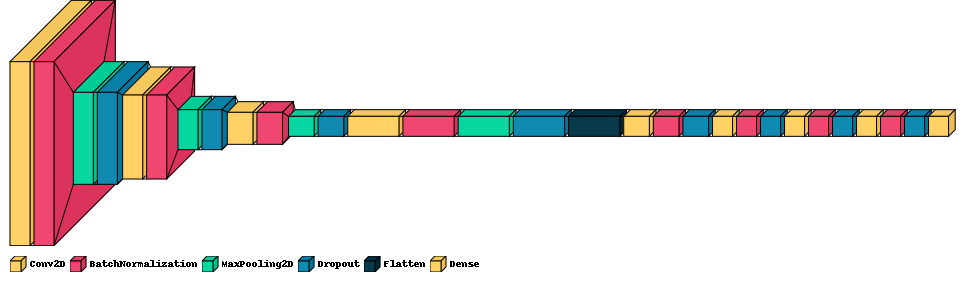

In [27]:
visualkeras.layered_view(c_model, legend=True, spacing=4, to_file='./images/custom_model.png')

In [28]:
c_history = c_model.fit(x=train_gen,
                        validation_data=validation_gen,
                        epochs=50,
                        batch_size=batch_size,
                        steps_per_epoch=steps_per_epoch,
                         callbacks=[c_checkpoint, c_reduce_lr])

Epoch 1/50
188/188 [==============================] - 61s 319ms/step - loss: 2.1402 - accuracy: 0.2488 - val_loss: 2.2407 - val_accuracy: 0.1590

Epoch 00001: val_accuracy improved from -inf to 0.15898, saving model to ./models\custom_checkpoint.h5
Epoch 2/50
188/188 [==============================] - 54s 288ms/step - loss: 1.7066 - accuracy: 0.3545 - val_loss: 1.7211 - val_accuracy: 0.3180

Epoch 00002: val_accuracy improved from 0.15898 to 0.31797, saving model to ./models\custom_checkpoint.h5
Epoch 3/50
188/188 [==============================] - 56s 295ms/step - loss: 1.5792 - accuracy: 0.3962 - val_loss: 1.5389 - val_accuracy: 0.3777

Epoch 00003: val_accuracy improved from 0.31797 to 0.37772, saving model to ./models\custom_checkpoint.h5
Epoch 4/50
188/188 [==============================] - 57s 302ms/step - loss: 1.4958 - accuracy: 0.4440 - val_loss: 1.5736 - val_accuracy: 0.3708

Epoch 00004: val_accuracy did not improve from 0.37772
Epoch 5/50
188/188 [==========================

188/188 [==============================] - 56s 295ms/step - loss: 0.8002 - accuracy: 0.7199 - val_loss: 0.7371 - val_accuracy: 0.7363

Epoch 00036: val_accuracy improved from 0.73478 to 0.73628, saving model to ./models\custom_checkpoint.h5
Epoch 37/50
188/188 [==============================] - 56s 296ms/step - loss: 0.8008 - accuracy: 0.7172 - val_loss: 0.7399 - val_accuracy: 0.7355

Epoch 00037: val_accuracy did not improve from 0.73628
Epoch 38/50
188/188 [==============================] - 56s 298ms/step - loss: 0.8011 - accuracy: 0.7179 - val_loss: 0.7315 - val_accuracy: 0.7393

Epoch 00038: val_accuracy improved from 0.73628 to 0.73929, saving model to ./models\custom_checkpoint.h5
Epoch 39/50
188/188 [==============================] - 56s 300ms/step - loss: 0.7968 - accuracy: 0.7208 - val_loss: 0.7468 - val_accuracy: 0.7338

Epoch 00039: val_accuracy did not improve from 0.73929
Epoch 40/50
188/188 [==============================] - 56s 298ms/step - loss: 0.7916 - accuracy: 0.725

In [29]:
c_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 21, 21, 128)       512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)      

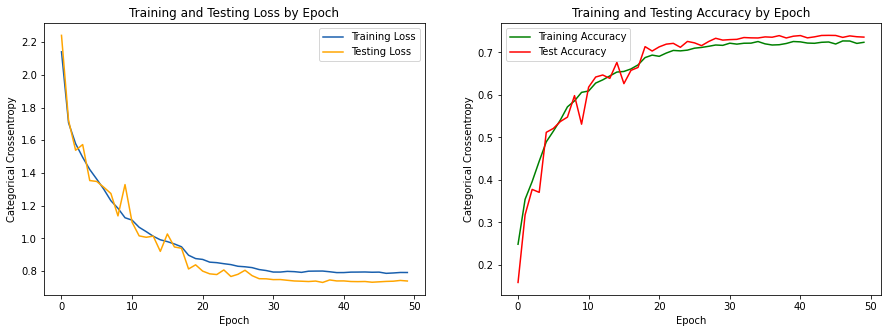

In [30]:
plot_acc_loss(c_history)

The custom model ultimately achieved an accuracy score of 74% against the validation set, with a loss of 0.74. We also see that there isn't much variance between the training and validation scores. The model seems to be performing quite well for a start. Note that the improvements start to minimalise around the 20th epoch onwards.

## VGG16

In [15]:
vgg_model = vgg16_model(class_size)
vgg_early, vgg_checkpoint, vgg_reduce_lr = callbacks('vgg16_1_checkpoint')

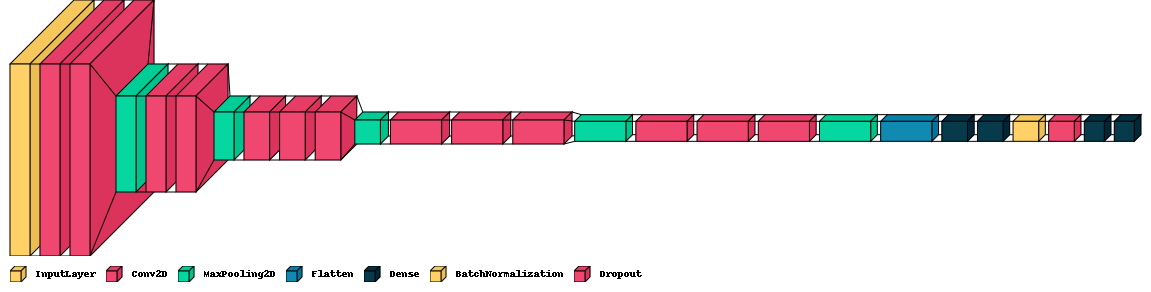

In [60]:
visualkeras.layered_view(vgg_model, legend=True, to_file='./images/VGG16_Model.png')

In [61]:
v_history = vgg_model.fit(x=train_gen,
                              validation_data=validation_gen,
                              epochs=50,
                              batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[vgg_checkpoint, vgg_reduce_lr])

Epoch 1/50
188/188 [==============================] - 35s 182ms/step - loss: 1.7238 - accuracy: 0.3279 - val_loss: 3.6975 - val_accuracy: 0.2641

Epoch 00001: val_accuracy improved from -inf to 0.26409, saving model to ./models\vgg16_1_checkpoint.h5
Epoch 2/50
188/188 [==============================] - 34s 180ms/step - loss: 1.6477 - accuracy: 0.3424 - val_loss: 1.8265 - val_accuracy: 0.3497

Epoch 00002: val_accuracy improved from 0.26409 to 0.34966, saving model to ./models\vgg16_1_checkpoint.h5
Epoch 3/50
188/188 [==============================] - 34s 181ms/step - loss: 1.5940 - accuracy: 0.3627 - val_loss: 2.0739 - val_accuracy: 0.3642

Epoch 00003: val_accuracy improved from 0.34966 to 0.36419, saving model to ./models\vgg16_1_checkpoint.h5
Epoch 4/50
188/188 [==============================] - 34s 180ms/step - loss: 1.5070 - accuracy: 0.4101 - val_loss: 1.6486 - val_accuracy: 0.4044

Epoch 00004: val_accuracy improved from 0.36419 to 0.40441, saving model to ./models\vgg16_1_check

In [16]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

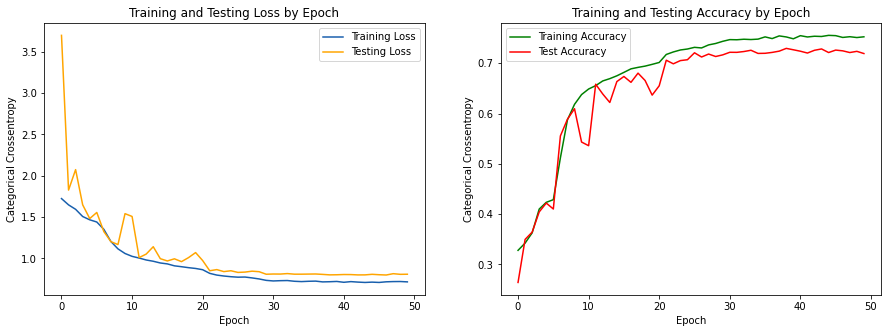

In [62]:
plot_acc_loss(v_history)

Surprisingly, the VGG16 model performs slightly poorer than the custom model, hitting a validation accuracy of 72%, with a loss of 0.81. Note the loss and accuracy plateauing after the 30th epoch onwards.

## VGG16 with Frozen Layers

In [17]:
vgg_frozen_model = vgg16_frozen_model(class_size)
vgg_f_early, vgg_f_checkpoint, vgg_f_reduce_lr = callbacks('vgg_f_checkpoint')

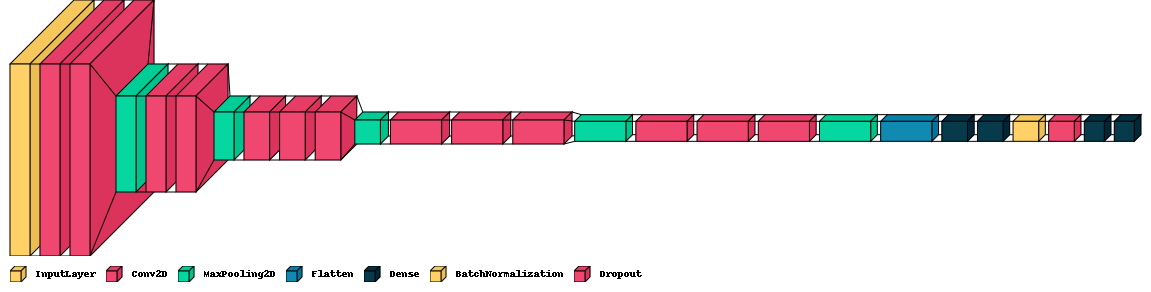

In [41]:
visualkeras.layered_view(vgg_frozen_model, legend=True, to_file='./images/VGG16_Frozen_Layers_Model.png')

In [40]:
vgg_f_history = vgg_frozen_model.fit(x=train_gen,
                                      validation_data=validation_gen,
                                      epochs=50,
                                      batch_size=batch_size,
                                      steps_per_epoch=steps_per_epoch,
                                      callbacks=[vgg_f_checkpoint, vgg_f_reduce_lr])

Epoch 1/50
188/188 [==============================] - 35s 182ms/step - loss: 1.6232 - accuracy: 0.3906 - val_loss: 1.5291 - val_accuracy: 0.3950

Epoch 00001: val_accuracy improved from -inf to 0.39501, saving model to ./models\vgg_f_checkpoint.h5
Epoch 2/50
188/188 [==============================] - 33s 178ms/step - loss: 1.4805 - accuracy: 0.4331 - val_loss: 1.4882 - val_accuracy: 0.4255

Epoch 00002: val_accuracy improved from 0.39501 to 0.42546, saving model to ./models\vgg_f_checkpoint.h5
Epoch 3/50
188/188 [==============================] - 33s 177ms/step - loss: 1.4487 - accuracy: 0.4481 - val_loss: 1.4366 - val_accuracy: 0.4553

Epoch 00003: val_accuracy improved from 0.42546 to 0.45527, saving model to ./models\vgg_f_checkpoint.h5
Epoch 4/50
188/188 [==============================] - 33s 178ms/step - loss: 1.4335 - accuracy: 0.4524 - val_loss: 1.4353 - val_accuracy: 0.4587

Epoch 00004: val_accuracy improved from 0.45527 to 0.45866, saving model to ./models\vgg_f_checkpoint.h5

In [18]:
vgg_frozen_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

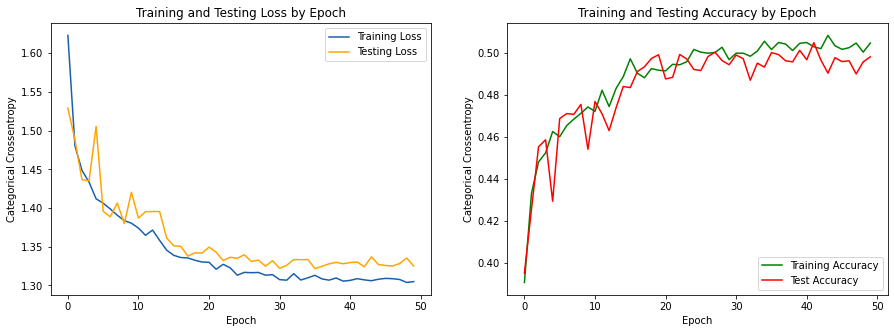

In [42]:
plot_acc_loss(vgg_f_history)

The VGG16 model with frozen weights performed worse than expected, hitting a peak validation accuracy at 50%, with a loss of 1.30. This could due to previously trained weights might not aid well against identifying facial expressions instead, and would therefore not contribute much to the learning rate.

## Resnet50

In [19]:
resnet_model = resnet50_model(class_size)
rn_early, rn_checkpoint, rn_reduce_lr = callbacks('resnet50_1_checkpoint')

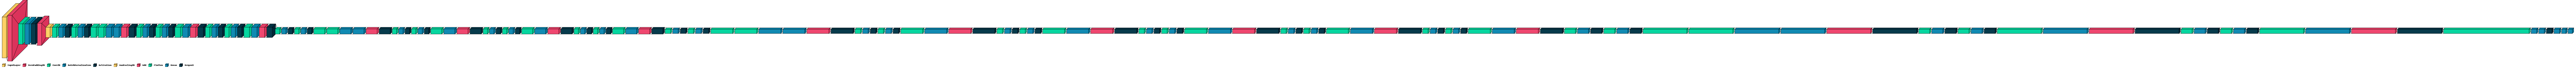

In [45]:
visualkeras.layered_view(resnet_model, legend=True, to_file='./images/Resnet50_Model.png')

In [44]:
rn_history = resnet_model.fit(x=train_gen,
                              validation_data=validation_gen,
                              epochs=50,
                              batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[rn_checkpoint, rn_reduce_lr])

Epoch 1/50
188/188 [==============================] - 40s 187ms/step - loss: 1.3689 - accuracy: 0.5095 - val_loss: 1.7525 - val_accuracy: 0.3647

Epoch 00001: val_accuracy improved from -inf to 0.36470, saving model to ./models\resnet50_1_checkpoint.h5


C:\Users\Seraphim\anaconda3\envs\gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
188/188 [==============================] - 34s 178ms/step - loss: 1.0659 - accuracy: 0.6303 - val_loss: 1.8990 - val_accuracy: 0.3647

Epoch 00002: val_accuracy did not improve from 0.36470
Epoch 3/50
188/188 [==============================] - 33s 177ms/step - loss: 0.9787 - accuracy: 0.6655 - val_loss: 1.6254 - val_accuracy: 0.4516

Epoch 00003: val_accuracy improved from 0.36470 to 0.45164, saving model to ./models\resnet50_1_checkpoint.h5
Epoch 4/50
188/188 [==============================] - 34s 178ms/step - loss: 0.9134 - accuracy: 0.6828 - val_loss: 1.4535 - val_accuracy: 0.4732

Epoch 00004: val_accuracy improved from 0.45164 to 0.47319, saving model to ./models\resnet50_1_checkpoint.h5
Epoch 5/50
188/188 [==============================] - 34s 178ms/step - loss: 0.8615 - accuracy: 0.6999 - val_loss: 1.2262 - val_accuracy: 0.5723

Epoch 00005: val_accuracy improved from 0.47319 to 0.57229, saving model to ./models\resnet50_1_checkpoint.h5
Epoch 6/50
188/188 [===========

In [20]:
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

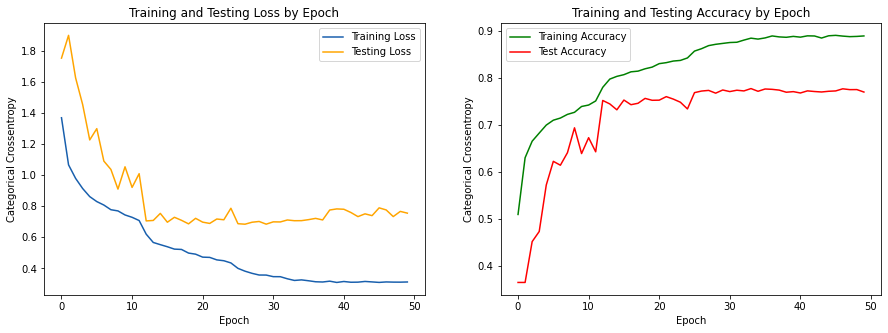

In [46]:
plot_acc_loss(rn_history)

The Resnet50 model achieved the highest validation accuracy so far, at 78% with a loss of 0.76. However, the difference of the accuracy and loss between the training and validation set suggests there is a slight bit of overfitting.

## Resnet152

In [47]:
rn152_model = resnet152_model(class_size)
rn152_early, rn152_checkpoint, rn152_reduce_lr = callbacks('resnet152_1_checkpoint')

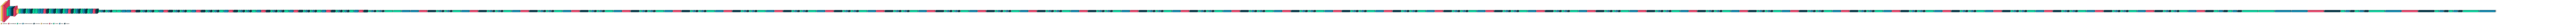

In [49]:
visualkeras.layered_view(rn152_model, legend=True, to_file='./images/Resnet152_Model.png')

In [48]:
rn152_history = rn152_model.fit(x=train_gen,
                              validation_data=validation_gen,
                              epochs=50,
                              batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[rn152_checkpoint, rn152_reduce_lr])

Epoch 1/50
188/188 [==============================] - 52s 203ms/step - loss: 1.4646 - accuracy: 0.4712 - val_loss: 5.1954 - val_accuracy: 0.1258

Epoch 00001: val_accuracy improved from -inf to 0.12578, saving model to ./models\resnet152_1_checkpoint.h5
Epoch 2/50
188/188 [==============================] - 36s 191ms/step - loss: 1.1527 - accuracy: 0.5967 - val_loss: 1.7094 - val_accuracy: 0.3666

Epoch 00002: val_accuracy improved from 0.12578 to 0.36657, saving model to ./models\resnet152_1_checkpoint.h5
Epoch 3/50
188/188 [==============================] - 36s 190ms/step - loss: 1.0443 - accuracy: 0.6356 - val_loss: 1.5688 - val_accuracy: 0.4197

Epoch 00003: val_accuracy improved from 0.36657 to 0.41969, saving model to ./models\resnet152_1_checkpoint.h5
Epoch 4/50
188/188 [==============================] - 36s 190ms/step - loss: 1.1574 - accuracy: 0.5980 - val_loss: 1.5926 - val_accuracy: 0.4268

Epoch 00004: val_accuracy improved from 0.41969 to 0.42684, saving model to ./models\r

188/188 [==============================] - 36s 193ms/step - loss: 0.7890 - accuracy: 0.7238 - val_loss: 20.4832 - val_accuracy: 0.7045

Epoch 00036: val_accuracy did not improve from 0.70471
Epoch 37/50
188/188 [==============================] - 36s 193ms/step - loss: 0.7872 - accuracy: 0.7166 - val_loss: 49.0162 - val_accuracy: 0.7025

Epoch 00037: val_accuracy did not improve from 0.70471
Epoch 38/50
188/188 [==============================] - 36s 192ms/step - loss: 0.7930 - accuracy: 0.7202 - val_loss: 76.7173 - val_accuracy: 0.7026

Epoch 00038: val_accuracy did not improve from 0.70471

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
Epoch 39/50
188/188 [==============================] - 37s 194ms/step - loss: 0.7879 - accuracy: 0.7202 - val_loss: 33.3376 - val_accuracy: 0.6978

Epoch 00039: val_accuracy did not improve from 0.70471
Epoch 40/50
188/188 [==============================] - 36s 192ms/step - loss: 0.7897 - accuracy: 0.7207 - val_loss: 49

In [51]:
rn152_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

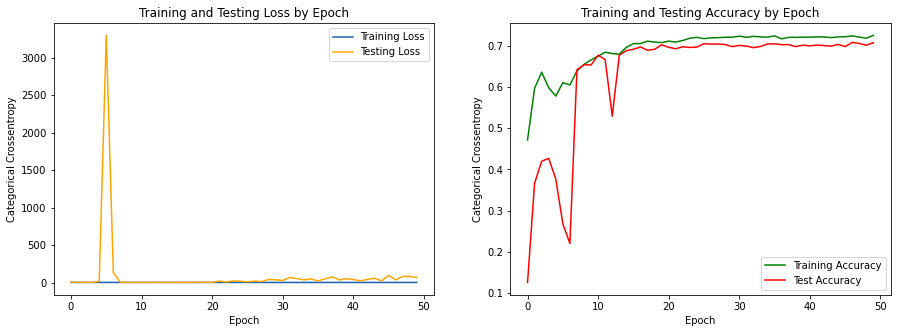

In [50]:
plot_acc_loss(rn152_history)

As a test to see if deeper layers would help improve the accuracy score, Resnet152 oddly didn't have an improved accuracy over Resnet50, hitting a validation accuracy at 71% with loss at 0.81. There are also spikes in the loss and accuracy against the validation set. 

## Resnet50 with Additional Layers

To test if adding slightly more layers to our original Resnet50 model will help improve accuracy, I did a test to add an additional 4 connected layers with Batch Normalisation and Dropouts to see if my accuracy will increase.

In [14]:
test_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48,3))
add_model = Flatten()(test_model.layers[-1].output)
add_model = Dense(256, activation='relu')(add_model)
add_model = BatchNormalization()(add_model)
add_model = Dropout(0.25)(add_model)
add_model = Dense(256, activation='relu')(add_model)
add_model = BatchNormalization()(add_model)
add_model = Dropout(0.25)(add_model)
add_model = Dense(128, activation='relu')(add_model)
add_model = BatchNormalization()(add_model)
add_model = Dropout(0.25)(add_model)
add_model = Dense(64, activation='relu')(add_model)
add_model = BatchNormalization()(add_model)
add_model = Dropout(0.25)(add_model)
add_model = Dense(class_size, activation='softmax')(add_model)

# for layer in test_model.layers:
#         layer.trainable=False

rn50_test_model = Model(inputs=test_model.inputs, outputs=add_model)

In [15]:
test_early, test_checkpoint, test_reduce_lr = callbacks('rn50_test_1_checkpoint')

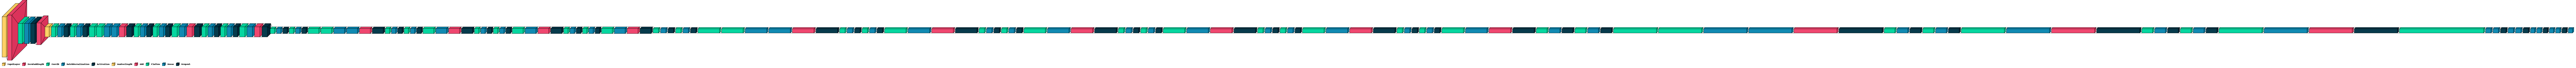

In [16]:
visualkeras.layered_view(rn50_test_model, legend=True, to_file='./images/Resnet50_additional.png')

In [17]:
rn50_test_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

In [18]:
test_history = rn50_test_model.fit(x=train_gen,
                              validation_data=validation_gen,
                              epochs=50,
                              batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[test_checkpoint, test_reduce_lr])

Epoch 1/50
188/188 [==============================] - 43s 182ms/step - loss: 2.0133 - accuracy: 0.3445 - val_loss: 74.1221 - val_accuracy: 0.3647

Epoch 00001: val_accuracy improved from -inf to 0.36470, saving model to ./models\rn50_test_1_checkpoint.h5


C:\Users\Seraphim\anaconda3\envs\gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
188/188 [==============================] - 33s 175ms/step - loss: 1.3015 - accuracy: 0.5735 - val_loss: 1.6479 - val_accuracy: 0.3648

Epoch 00002: val_accuracy improved from 0.36470 to 0.36482, saving model to ./models\rn50_test_1_checkpoint.h5
Epoch 3/50
188/188 [==============================] - 33s 173ms/step - loss: 1.1124 - accuracy: 0.6214 - val_loss: 1.7642 - val_accuracy: 0.4100

Epoch 00003: val_accuracy improved from 0.36482 to 0.41005, saving model to ./models\rn50_test_1_checkpoint.h5
Epoch 4/50
188/188 [==============================] - 33s 173ms/step - loss: 1.0156 - accuracy: 0.6538 - val_loss: 1.2710 - val_accuracy: 0.5535

Epoch 00004: val_accuracy improved from 0.41005 to 0.55350, saving model to ./models\rn50_test_1_checkpoint.h5
Epoch 5/50
188/188 [==============================] - 33s 174ms/step - loss: 0.9690 - accuracy: 0.6664 - val_loss: 1.0686 - val_accuracy: 0.6287

Epoch 00005: val_accuracy improved from 0.55350 to 0.62866, saving model to ./model

188/188 [==============================] - 33s 176ms/step - loss: 0.3762 - accuracy: 0.8749 - val_loss: 0.7250 - val_accuracy: 0.7695

Epoch 00037: val_accuracy did not improve from 0.77274
Epoch 38/50
188/188 [==============================] - 33s 175ms/step - loss: 0.3712 - accuracy: 0.8766 - val_loss: 0.7061 - val_accuracy: 0.7727

Epoch 00038: val_accuracy did not improve from 0.77274
Epoch 39/50
188/188 [==============================] - 33s 177ms/step - loss: 0.3620 - accuracy: 0.8816 - val_loss: 0.7145 - val_accuracy: 0.7747

Epoch 00039: val_accuracy improved from 0.77274 to 0.77474, saving model to ./models\rn50_test_1_checkpoint.h5
Epoch 40/50
188/188 [==============================] - 33s 176ms/step - loss: 0.3692 - accuracy: 0.8804 - val_loss: 0.7275 - val_accuracy: 0.7682

Epoch 00040: val_accuracy did not improve from 0.77474
Epoch 41/50
188/188 [==============================] - 33s 177ms/step - loss: 0.3556 - accuracy: 0.8824 - val_loss: 0.7276 - val_accuracy: 0.7717

E

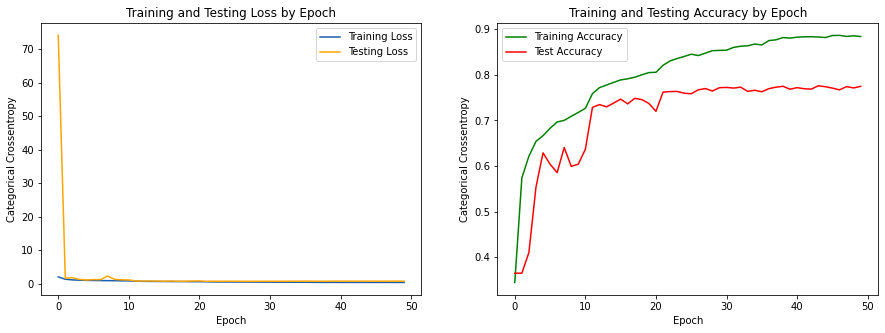

In [19]:
plot_acc_loss(test_history)

Looking at Resnet50 being the best performing model, I attempted to add more connected layers at the end to try and push for a better validation accuracy score. Note that the score still reaches 78% (or 77.57%), which is off our earlier Resnet50 model by a miniscule bit. However, the initial loss on the first epoch is very high, as compared to the earlier Resnet50 model which shows a rather stable loss amount.

# Misclassification Analysis

To reduce the time required to fit and re-train our models, we load the saved '.h5' models, which have already been pretrained and exported, thanks to checkpoints.

In [15]:
custom_model = load_model('./models/custom_73991.h5')
vgg_model = load_model('./models/vgg16_72964.h5')
rn50_model = load_model('./models/resnet50_78627.h5')
rn152_model = load_model('./models/resnet152_70784.h5')
rn50_test_model = load_model('./models/rn50_test_77575.h5')

In [16]:
c_misclass = get_misclassifications(custom_model)
vgg_misclass = get_misclassifications(vgg_model)
rn50_misclass = get_misclassifications(rn50_model)
rn152_misclass = get_misclassifications(rn152_model)
rn50_test_misclass = get_misclassifications(rn50_test_model)

In [17]:
c_summarise = pd.DataFrame()
c_summarise.append([c_misclass.loc[c_misclass['filename'].str.contains('anger'),:].head(1),
                    c_misclass.loc[c_misclass['filename'].str.contains('contempt'),:].head(1),
                    c_misclass.loc[c_misclass['filename'].str.contains('disgust'),:].head(1),
                    c_misclass.loc[c_misclass['filename'].str.contains('fear'),:].head(1),
                    c_misclass.loc[c_misclass['filename'].str.contains('happiness'),:].head(1),
                    c_misclass.loc[c_misclass['filename'].str.contains('neutral'),:].head(1),
                    c_misclass.loc[c_misclass['filename'].str.contains('sadness'),:].head(1),
                    c_misclass.loc[c_misclass['filename'].str.contains('surprise'),:].head(1)])

,true_class,predicted_class,filename
0,0,3,anger\anger_10.png
696,1,0,contempt\contempt_10156.png
743,2,4,disgust\disgust_10018.png
799,3,7,fear\fear_10030.png
984,4,5,happiness\happiness_10007.png
3086,5,7,neutral\neutral_0.png
5997,6,5,sadness\sadness_10006.png
6978,7,5,surprise\surprise_10013.png


In [18]:
vgg_summarise = pd.DataFrame()
vgg_summarise.append([vgg_misclass.loc[vgg_misclass['filename'].str.contains('anger'),:].head(1),
                    vgg_misclass.loc[vgg_misclass['filename'].str.contains('contempt'),:].head(1),
                    vgg_misclass.loc[vgg_misclass['filename'].str.contains('disgust'),:].head(1),
                    vgg_misclass.loc[vgg_misclass['filename'].str.contains('fear'),:].head(1),
                    vgg_misclass.loc[vgg_misclass['filename'].str.contains('happiness'),:].head(1),
                    vgg_misclass.loc[vgg_misclass['filename'].str.contains('neutral'),:].head(1),
                    vgg_misclass.loc[vgg_misclass['filename'].str.contains('sadness'),:].head(1),
                    vgg_misclass.loc[vgg_misclass['filename'].str.contains('surprise'),:].head(1)])

,true_class,predicted_class,filename
0,0,4,anger\anger_10.png
696,1,5,contempt\contempt_10156.png
743,2,4,disgust\disgust_10018.png
799,3,5,fear\fear_10030.png
981,4,5,happiness\happiness_10000.png
3087,5,4,neutral\neutral_1.png
5997,6,7,sadness\sadness_10006.png
6978,7,5,surprise\surprise_10013.png


In [19]:
rn50_summarise = pd.DataFrame()
rn50_summarise.append([rn50_misclass.loc[rn50_misclass['filename'].str.contains('anger'),:].head(1),
                    rn50_misclass.loc[rn50_misclass['filename'].str.contains('contempt'),:].head(1),
                    rn50_misclass.loc[rn50_misclass['filename'].str.contains('disgust'),:].head(1),
                    rn50_misclass.loc[rn50_misclass['filename'].str.contains('fear'),:].head(1),
                    rn50_misclass.loc[rn50_misclass['filename'].str.contains('happiness'),:].head(1),
                    rn50_misclass.loc[rn50_misclass['filename'].str.contains('neutral'),:].head(1),
                    rn50_misclass.loc[rn50_misclass['filename'].str.contains('sadness'),:].head(1),
                    rn50_misclass.loc[rn50_misclass['filename'].str.contains('surprise'),:].head(1)])

,true_class,predicted_class,filename
0,0,4,anger\anger_10.png
696,1,4,contempt\contempt_10156.png
743,2,5,disgust\disgust_10018.png
799,3,5,fear\fear_10030.png
980,4,3,happiness\happiness_100.png
3086,5,7,neutral\neutral_0.png
5997,6,5,sadness\sadness_10006.png
6978,7,0,surprise\surprise_10013.png


In [20]:
rn152_summarise = pd.DataFrame()
rn152_summarise.append([rn152_misclass.loc[rn152_misclass['filename'].str.contains('anger'),:].head(1),
                    rn152_misclass.loc[rn152_misclass['filename'].str.contains('contempt'),:].head(1),
                    rn152_misclass.loc[rn152_misclass['filename'].str.contains('disgust'),:].head(1),
                    rn152_misclass.loc[rn152_misclass['filename'].str.contains('fear'),:].head(1),
                    rn152_misclass.loc[rn152_misclass['filename'].str.contains('happiness'),:].head(1),
                    rn152_misclass.loc[rn152_misclass['filename'].str.contains('neutral'),:].head(1),
                    rn152_misclass.loc[rn152_misclass['filename'].str.contains('sadness'),:].head(1),
                    rn152_misclass.loc[rn152_misclass['filename'].str.contains('surprise'),:].head(1)])

,true_class,predicted_class,filename
0,0,4,anger\anger_10.png
696,1,4,contempt\contempt_10156.png
743,2,7,disgust\disgust_10018.png
799,3,4,fear\fear_10030.png
980,4,7,happiness\happiness_100.png
3086,5,4,neutral\neutral_0.png
5997,6,0,sadness\sadness_10006.png
6978,7,4,surprise\surprise_10013.png


In [21]:
rn50_test_summarise = pd.DataFrame()
rn50_test_summarise.append([rn50_test_misclass.loc[rn50_test_misclass['filename'].str.contains('anger'),:].head(1),
                            rn50_test_misclass.loc[rn50_test_misclass['filename'].str.contains('contempt'),:].head(1),
                            rn50_test_misclass.loc[rn50_test_misclass['filename'].str.contains('disgust'),:].head(1),
                            rn50_test_misclass.loc[rn50_test_misclass['filename'].str.contains('fear'),:].head(1),
                            rn50_test_misclass.loc[rn50_test_misclass['filename'].str.contains('happiness'),:].head(1),
                            rn50_test_misclass.loc[rn50_test_misclass['filename'].str.contains('neutral'),:].head(1),
                            rn50_test_misclass.loc[rn50_test_misclass['filename'].str.contains('sadness'),:].head(1),
                            rn50_test_misclass.loc[rn50_test_misclass['filename'].str.contains('surprise'),:].head(1)])

,true_class,predicted_class,filename
0,0,4,anger\anger_10.png
696,1,4,contempt\contempt_10156.png
743,2,4,disgust\disgust_10018.png
800,3,4,fear\fear_10105.png
981,4,5,happiness\happiness_10000.png
3086,5,4,neutral\neutral_0.png
5997,6,5,sadness\sadness_10006.png
6978,7,4,surprise\surprise_10013.png


In [22]:
comb_misclass = c_misclass.merge(vgg_misclass, how='inner',on='filename')
comb_misclass = comb_misclass.merge(rn50_misclass, how='inner',on='filename')
comb_misclass = comb_misclass.merge(rn152_misclass, how='inner',on='filename')
comb_misclass = comb_misclass.merge(rn50_test_misclass, how='inner',on='filename')
comb_misclass = comb_misclass[['filename']]

C:\Users\Seraphim\anaconda3\envs\gpu\lib\site-packages\pandas\core\frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'predicted_class_x', 'true_class_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [26]:
legend = pd.DataFrame([class_names]).T
legend.rename(columns={
    0:'emotion_name',
}, inplace=True)

In [27]:
legend

,emotion_name
0,anger
1,contempt
2,disgust
3,fear
4,happiness
5,neutral
6,sadness
7,surprise


In [28]:
comb_misclass.loc[comb_misclass['filename'].str.contains('anger')].head(5)

,filename
0,anger\anger_10.png
1,anger\anger_10026.png
2,anger\anger_10047.png
3,anger\anger_10059.png
4,anger\anger_1006.png


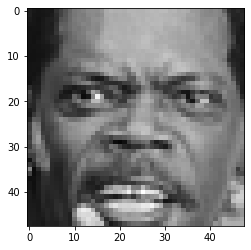

In [29]:
plt.imshow(cv2.imread(train_path + 'anger/anger_10.png'))

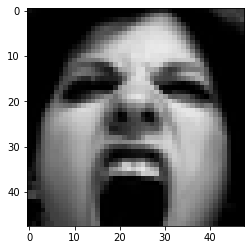

In [30]:
plt.imshow(cv2.imread(train_path + 'anger/anger_10026.png'))

Taking the first common misclassified image of the anger emotion, note that most of the misclassfied label is happiness. Other models classified this image as either neutral, sadness or surprise instead. I loaded the second misclassified label for anger and realised it is mostly misclassified as neutral or happiness. This could be due to the exposure of teeth, which may confuse anger with happiness instead.

In [31]:
comb_misclass.loc[comb_misclass['filename'].str.contains('contempt')].head(5)

,filename
456,contempt\contempt_10156.png
457,contempt\contempt_10204.png
458,contempt\contempt_10587.png
459,contempt\contempt_10625.png
460,contempt\contempt_10890.png


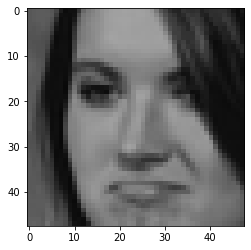

In [32]:
plt.imshow(cv2.imread(train_path + 'contempt/contempt_10156.png'))

Contempt is a very challenging emotion to understand, as it resembles the neutral emotion. Note that there were 2 common occurences of misclassification of `neutral` in our models for this emotion

In [33]:
comb_misclass.loc[comb_misclass['filename'].str.contains('disgust')].head(5)

,filename
503,disgust\disgust_10018.png
504,disgust\disgust_10542.png
505,disgust\disgust_10600.png
506,disgust\disgust_10834.png
507,disgust\disgust_10989.png


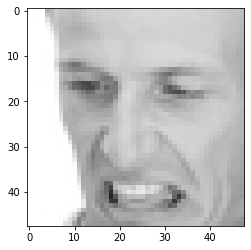

In [34]:
plt.imshow(cv2.imread(train_path + 'disgust/disgust_10018.png'))

Having 2 misclassifications of `happiness` and 3 on `neutral`, this is likely to be similar with the problem on differentiating anger and happiness. The disgust emotion sometimes shows teeth, which could be mistaken as an emotion of happiness from the model itself.

In [35]:
comb_misclass.loc[comb_misclass['filename'].str.contains('fear')].head(5)

,filename
559,fear\fear_10105.png
560,fear\fear_10202.png
561,fear\fear_10236.png
562,fear\fear_10256.png
563,fear\fear_10313.png


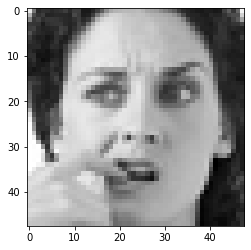

In [36]:
plt.imshow(cv2.imread(train_path + 'fear/fear_10030.png'))

On assessing the misclassifications for the `fear` emotion, I noticed most of the models misclassified as `neutral`. Although I would expect the misclassifications to be closer to the `surprise` due to raised eyebrows when dealing with such emotions. There is a possibility that the dataset pertaining to fear might be insufficient to make a clear distinction on emotions of fear.

In [37]:
comb_misclass.loc[comb_misclass['filename'].str.contains('happiness')].head(5)

,filename
723,happiness\happiness_10012.png
724,happiness\happiness_10017.png
725,happiness\happiness_10029.png
726,happiness\happiness_10031.png
727,happiness\happiness_10040.png


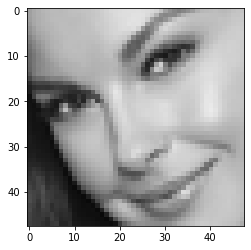

In [38]:
plt.imshow(cv2.imread(train_path + 'happiness/happiness_10000.png'))

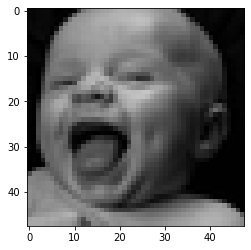

In [39]:
plt.imshow(cv2.imread(train_path + 'happiness/happiness_100.png'))

Looking at the 2 images, it is highly likely our misclassifications for the `happiness` emotion are due to the absence of teeth, or the brighter areas between the mouth. Misclassfications mostly are classified as `neutral` instead, which usually shows images of faces without large smiles.

In [40]:
comb_misclass.loc[comb_misclass['filename'].str.contains('neutral')].head(5)

,filename
1163,neutral\neutral_10048.png
1164,neutral\neutral_10076.png
1165,neutral\neutral_10077.png
1166,neutral\neutral_10121.png
1167,neutral\neutral_10143.png


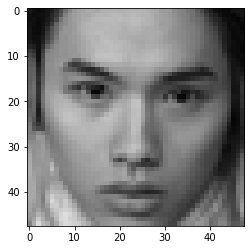

In [41]:
plt.imshow(cv2.imread(train_path + 'neutral/neutral_10082.png'))

Neutral is an emotion that most likely arises from lips without any smile or sadness. Our misclassifications come from the image being misclassified as `happiness` or `anger` mostly. This could be due to neutral facial structures being mistaken as an emotion instead.

In [42]:
comb_misclass.loc[comb_misclass['filename'].str.contains('sadness')].head(5)

,filename
1342,sadness\sadness_10006.png
1343,sadness\sadness_10021.png
1344,sadness\sadness_10028.png
1345,sadness\sadness_10042.png
1346,sadness\sadness_10094.png


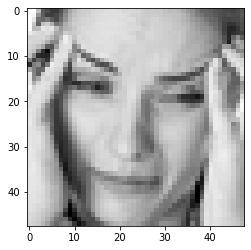

In [43]:
plt.imshow(cv2.imread(train_path + 'sadness/sadness_10020.png'))

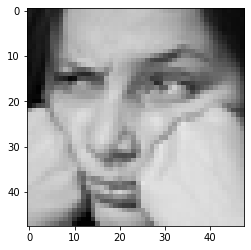

In [44]:
plt.imshow(cv2.imread(train_path + 'sadness/sadness_10006.png'))

Looking at the misclassified images for `sadness`, it seems that most of the images are misclassified due to pictures with hands reflecting signs of thinking or stressful periods, which may have obscured key features on the face itself. Additionally, the images show a `neutral` smile, which may be the reason for misclassifications to `neutral` emotions instead.

In [45]:
comb_misclass.loc[comb_misclass['filename'].str.contains('surprise')].head(5)

,filename
1951,surprise\surprise_10013.png
1952,surprise\surprise_10046.png
1953,surprise\surprise_10049.png
1954,surprise\surprise_10067.png
1955,surprise\surprise_10075.png


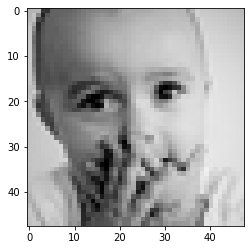

In [46]:
plt.imshow(cv2.imread(train_path + 'surprise\surprise_10013.png'))

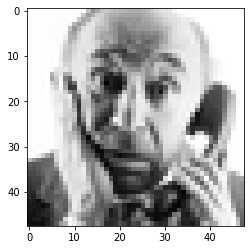

In [47]:
plt.imshow(cv2.imread(train_path + 'surprise\surprise_10096.png'))

Misclassifications for the `surprise` emotion could be due to "noise" within the data, such as a phone, or hands covering the mouth which could be a key indictor for a specific emotion.

# Model Evaluation

In [48]:
test_datagen = ImageDataGenerator(rescale=1./255, 
                                   brightness_range=[0.2,1.0],
                                   rotation_range=30,
                                   shear_range=0.2,
                                   channel_shift_range=10
                                  )

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=(48,48),
    seed=42,
    color_mode='rgb'
)

Found 3546 images belonging to 8 classes.


In [49]:
def evaluate_model(model, test=test_gen):
    loss, acc = model.evaluate(test, verbose=1)
    return loss, acc

In [50]:
evaluate_model(custom_model)

111/111 [==============================] - 15s 131ms/step - loss: 0.7271 - accuracy: 0.7366


(0.727136492729187, 0.736604630947113)

In [51]:
evaluate_model(vgg_model)

111/111 [==============================] - 4s 36ms/step - loss: 0.7664 - accuracy: 0.7349


(0.7664217352867126, 0.7349125742912292)

In [52]:
evaluate_model(rn50_model)

111/111 [==============================] - 5s 36ms/step - loss: 0.7076 - accuracy: 0.7862


(0.7075821757316589, 0.7862380146980286)

In [53]:
evaluate_model(rn152_model)

111/111 [==============================] - 7s 41ms/step - loss: 15.7561 - accuracy: 0.7126


(15.756103515625, 0.7126339673995972)

In [54]:
evaluate_model(rn50_test_model)

111/111 [==============================] - 5s 34ms/step - loss: 0.7247 - accuracy: 0.7837


(0.724708616733551, 0.7836999297142029)

We can see that when we evaluate the models against unseen data in the test folders, our Resnet50 model still performs with the best accuracy. Additionally, the accuracy does not differ too much from our validation set, which suggests that the accuracy of the model is not too underfitted, and is able to generalise to unseen data 77% of the time.

# Testing with random images

To run and apply our model on detecting emotions from faces, faces from the provided images must be identified and 'extracted'. This would be the region of interest, or `roi`, to apply our emotion classification model. To do that, I use a pre-trained Haar Cascade classifier in OpenCV to detect faces. The classifier is even able to detect multiple faces within an image. For each detected face, we then do a prediction using our model to get the emotion of that particular face.

In [10]:
face_cascade = cv2.CascadeClassifier('./applications/haarcascade_frontalface_default.xml')
class_labels = list(test_gen.class_indices.keys())

In [55]:
def get_emotion_from_image(img, model):
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=12)
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
        roi_gray=img[y:y+h,x:x+w]
        roi_gray=cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray])!=0:
            roi=roi_gray.astype('float')/255.0
            roi=img_to_array(roi)
            roi=np.expand_dims(roi,axis=0)
            preds=model.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position=(x,y)
            cv2.putText(img,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)

    return img

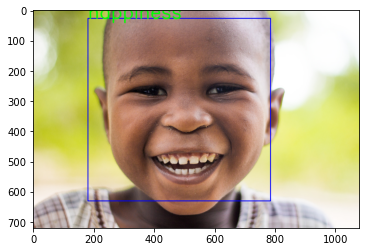

In [56]:
img = cv2.cvtColor(cv2.imread('./images/happy.jpg'),cv2.COLOR_BGR2RGB)
face = get_emotion_from_image(img, rn50_model)
plt.imshow(face)

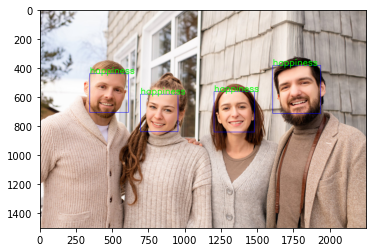

In [57]:
grp_img = cv2.cvtColor(cv2.imread('./images/group_happy.jpeg'),cv2.COLOR_BGR2RGB)
grp_photo = get_emotion_from_image(grp_img, rn50_model)
plt.imshow(grp_photo)

As mentioned earlier, we can do multiple facial emotion detection for multiple faces in a single image.

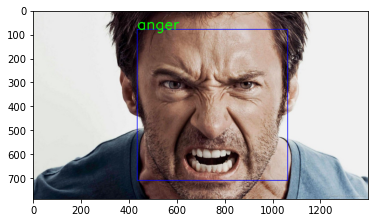

In [58]:
anger_img = cv2.cvtColor(cv2.imread('./images/anger.jpeg'),cv2.COLOR_RGB2BGR)
anger_result = get_emotion_from_image(anger_img, rn50_model)
plt.imshow(anger_result)

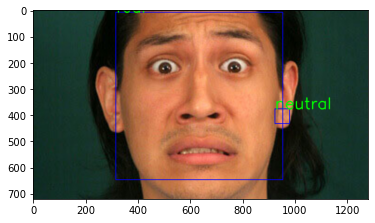

In [59]:
fear_img = cv2.cvtColor(cv2.imread('./images/fear.jpg'), cv2.COLOR_BGR2RGB)
fear_result = get_emotion_from_image(fear_img, rn50_model)
plt.imshow(fear_result)

However, this also depends on the accuracy of detection for facial features. Note that the classifier sometimes wrongly detects faces, as seen by the ear being bounded and detected as a face.

Our model is still performing correctly here, where the correct emotion of `fear` is classified here.

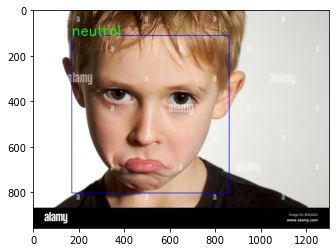

In [60]:
sad_img = cv2.cvtColor(cv2.imread('./images/sadness.jpg'), cv2.COLOR_BGR2RGB)
sad_result = get_emotion_from_image(sad_img, rn50_model)
plt.imshow(sad_result)

Our model still has problems with identifying certain facial emotions, based on the incorrectly classified image above, classified as `neutral` instead of `sadness`.

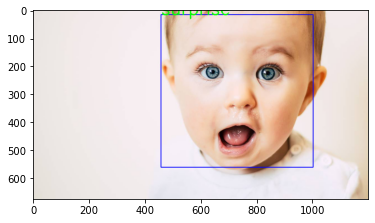

In [61]:
surprise_img = cv2.cvtColor(cv2.imread('./images/surprise.jpg'), cv2.COLOR_BGR2RGB)
surprise_result = get_emotion_from_image(surprise_img, rn50_model)
plt.imshow(surprise_result)

Emotions such as `surprise` are still classified correctly here.

# Conclusions and Further Improvements

While testing with identifying certain emotions, emotions such as `contempt` and `disgust` are still difficult to classify. This could likely be due to the lack of training data for those emotions.

Better qualities and larger quantities of images could also aid in clearly segregating the different emotions. There are images within the training dataset that has watermarks. These watermarks lighten/darken certain regions of images where key facial features of emotions are important in their classification.

The dataset used in FER is primarily grayscale, but our model is still able correctly identify the correct emotion on coloured images as they are preprocessed within our function to grayscale images. Certain features which may be minute, but will provide distinctive features for the models to train against. However, coloured images may take longer to train as they have higher channels.

In terms of modelling, while it may not necessarily guarantee higher accuracy, there are definitely more pre-trained models that can be used here, such as AlexNet.

There are also deeper facial features that can be focused on. Certain facial detection projects look specifically deeper into eyes, forehead, mouth, nose, to identify areas of interest for certain emotion classes.

Ideally, this project can still be further expanded for more classes of emotions, provided there are images to train. As this project was initially conceived based on wanting to understand people's emotions due to lifestyle and occupational transitions of remote work due to COVID-19, it can be redesigned to incorporate speech recognition to identify tonal changes in conversations to further improve identifying changes in an individual's expressions and feelings during video and/or voice calls.